In [ ]:
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import os
import numpy as np
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import tensorflow as tf

Resizing images and masks from ./CrackDataset/train/images/ and ./CrackDataset/train/masks/


100%|██████████| 468/468 [04:02<00:00,  1.93it/s]


Resizing images and masks from ./CrackDataset/train/images/ and ./CrackDataset/train/masks/


100%|██████████| 468/468 [04:02<00:00,  1.93it/s]


Resizing test images from ./CrackDataset/test/images/


100%|██████████| 25/25 [00:12<00:00,  2.08it/s]


Resizing test images from ./CrackDataset/test/masks/


100%|██████████| 25/25 [00:00<00:00, 116.79it/s]


X_train shape: (468, 128, 128, 3), dtype: uint8
Y_train shape: (468, 128, 128, 1), dtype: float32
X_test shape: (25, 128, 128, 3), dtype: uint8
Y_test shape: (25, 128, 128, 1), dtype: float32
Done!


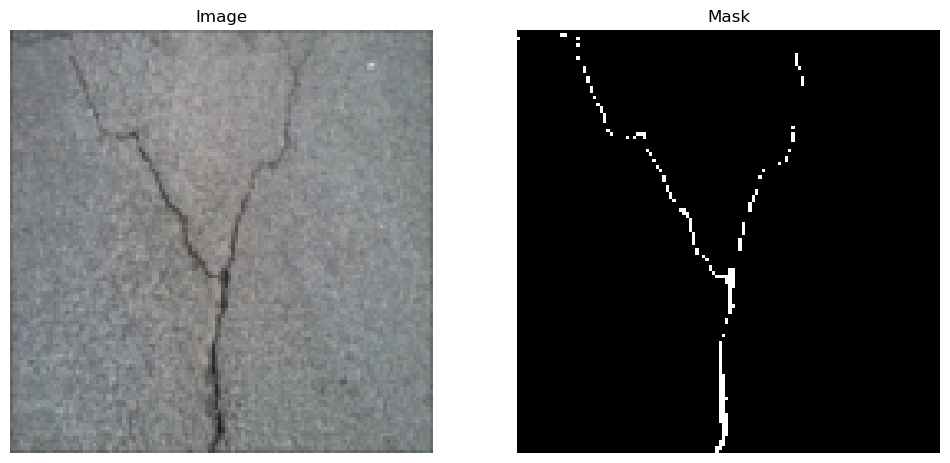

In [ ]:


# Constants
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Dataset paths
train_images_dir = "./CrackDataset/train/images/"
train_masks_dir = "./CrackDataset/train/masks/"
test_images_dir = "./CrackDataset/test/images/"
test_masks_dir = "./CrackDataset/test/masks/"

# Helper function to load images and masks
def load_data(image_dir, mask_dir, img_height, img_width, img_channels):
    ids = next(os.walk(image_dir))[2]  # List of file names in the images directory
    X = np.zeros((len(ids), img_height, img_width, img_channels), dtype=np.uint8)
    Y = np.zeros((len(ids), img_height, img_width, 1), dtype=np.uint8)  # Changed to uint8

    print(f"Resizing images and masks from {image_dir} and {mask_dir}")
    for n, file_id in tqdm(enumerate(ids), total=len(ids)):
        # Skip non-image files
        # if not file_id.endswith(('.jpg', '.png', '.jpeg')):
        #     print(f"Skipping non-image file: {file_id}")
        #     continue

        # Load and resize image
        img_path = os.path.join(image_dir, file_id)
        img = imread(img_path)
        if img.ndim == 2:  # If grayscale, add a channel dimension
            img = np.stack((img,) * img_channels, axis=-1)
        elif img.shape[2] > img_channels:  # Handle excess channels
            img = img[:, :, :img_channels]
        img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
        X[n] = img

        # Construct corresponding mask file name
        mask_file_id = os.path.splitext(file_id)[0] + '_mask.png'
        mask_path = os.path.join(mask_dir, mask_file_id)
        if not os.path.exists(mask_path):
            print(f"Mask file not found: {mask_path}")
            continue

        # Load and resize mask
        mask = imread(mask_path)
        if mask.ndim == 3:  # Convert color mask to grayscale if necessary
            mask = mask[:, :, 0]
        mask = np.expand_dims(resize(mask, (img_height, img_width), mode='constant', preserve_range=True), axis=-1)
        Y[n] = mask

    return X, Y

# Load training data
X_train, Y_train = load_data(train_images_dir, train_masks_dir, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# Load test data
def load_test_data(image_dir, img_height, img_width, img_channels):
    ids = next(os.walk(image_dir))[2]
    X = np.zeros((len(ids), img_height, img_width, img_channels), dtype=np.uint8)
    sizes = []

    print(f"Resizing test images from {image_dir}")
    for n, file_id in tqdm(enumerate(ids), total=len(ids)):
        # Skip non-image files
        # if not file_id.endswith(('.jpg', '.png', '.jpeg')):
        #     print(f"Skipping non-image file: {file_id}")
        #     continue

        img_path = os.path.join(image_dir, file_id)
        img = imread(img_path)
        sizes.append((img.shape[0], img.shape[1]))  # Save original sizes
        if img.ndim == 2:  # If grayscale, add a channel dimension
            img = np.stack((img,) * img_channels, axis=-1)
        elif img.shape[2] > img_channels:  # Handle excess channels
            img = img[:, :, :img_channels]
        img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
        X[n] = img

    return X, sizes

# Load training and test data
X_train, Y_train = load_data(train_images_dir, train_masks_dir, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
X_test, sizes_test1 = load_test_data(test_images_dir, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
Y_test, sizes_test2 = load_test_data(test_masks_dir, IMG_HEIGHT, IMG_WIDTH, 1)  # Masks have 1 channel

# Convert ground truth masks to float32
Y_train = Y_train.astype(np.float32)
Y_test = Y_test.astype(np.float32)

print(f"X_train shape: {X_train.shape}, dtype: {X_train.dtype}")
print(f"Y_train shape: {Y_train.shape}, dtype: {Y_train.dtype}")
print(f"X_test shape: {X_test.shape}, dtype: {X_test.dtype}")
print(f"Y_test shape: {Y_test.shape}, dtype: {Y_test.dtype}")

print('Done!')

# Visualize a random training image and its mask
image_x = random.randint(0, len(X_train) - 1)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(X_train[image_x])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(np.squeeze(Y_train[image_x]), cmap='gray')
plt.axis('off')

plt.show()


In [ ]:
#!/usr/bin/env python
__author__ = "Sreenivas Bhattiprolu"
__license__ = "Feel free to copy, I appreciate if you acknowledge Python for Microscopists"

# https://www.youtube.com/watch?v=68HR_eyzk00


"""
@author: Sreenivas Bhattiprolu
"""

#Build the model
# Build the simplified model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255.0)(inputs)

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)  # Lower dropout in shallow layers
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.2)(c2)  # Slightly higher dropout
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.3)(c3)  # Moderately higher dropout
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

# Bottleneck
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.4)(c4)  # Higher dropout in the bottleneck
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

# Expansive path
u5 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
u5 = tf.keras.layers.concatenate([u5, c3])
c5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

u6 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c2])
c6 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c1])
c7 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.1)(c7)
c7 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])



# Debug print after building the model
print("Model built successfully. Compiling the model...")

def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'), axis=(1, 2))
    precision = tp / (tf.reduce_sum(tf.cast(y_pred, 'float'), axis=(1, 2)) + tf.keras.backend.epsilon())
    recall = tp / (tf.reduce_sum(tf.cast(y_true, 'float'), axis=(1, 2)) + tf.keras.backend.epsilon())
    return tf.reduce_mean(2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon())))

def iou_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2))
    union = tf.reduce_sum(y_true + y_pred, axis=(1, 2)) - intersection
    return tf.reduce_mean(intersection / (union + tf.keras.backend.epsilon()))


# Compile the model

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        f1_score,
        iou_score
    ]
)

# Debug print after compilation
print("Model compiled successfully. Here is the summary:")
model.summary()

# Add model checkpointing
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    'model_for_pavement_cracks.keras', verbose=1, save_best_only=True
)

# Early stopping and TensorBoard callbacks
# Early stopping and TensorBoard callbacks
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
     tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',  # Metric to monitor
        patience=10,         # Number of epochs with no improvement before stopping
        verbose=1,           # Prints messages when stopping
        restore_best_weights=True  # Restores weights from the best epoch
    )
]



# Print information about the dataset
print("Dataset prepared. Starting training...")
print(f"Training dataset shape: {X_train.shape}, Labels shape: {Y_train.shape}")


# Start training
try:
    results = model.fit(
        X_train, Y_train,
        validation_split=0.1,
        batch_size=32,
        epochs=200,
        callbacks=callbacks
    )
    print("Training completed successfully.")
except Exception as e:
    print(f"An error occurred during training: {e}")

NameError: name 'tf' is not defined

# Plot Training and Validation Loss

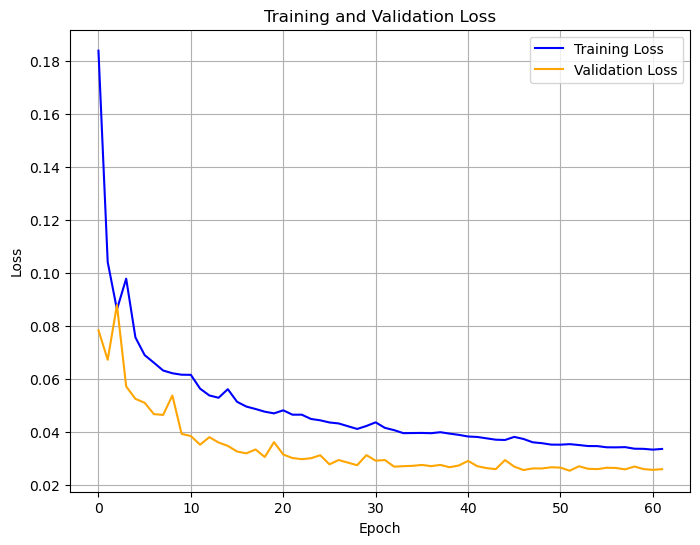

In [ ]:
import matplotlib.pyplot as plt

# After training, plot the training and validation loss
def plot_training_history(history):
    # Extract loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot loss
    plt.figure(figsize=(8, 6))
    plt.plot(loss, label='Training Loss', color='blue')
    plt.plot(val_loss, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function with the history object returned by model.fit()
plot_training_history(results)


# Inference

14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 744ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
Train Images


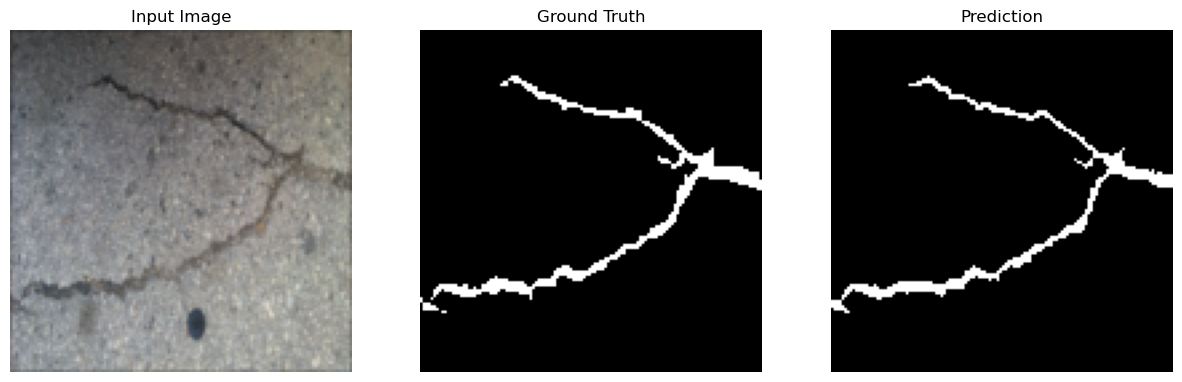

Validation Images


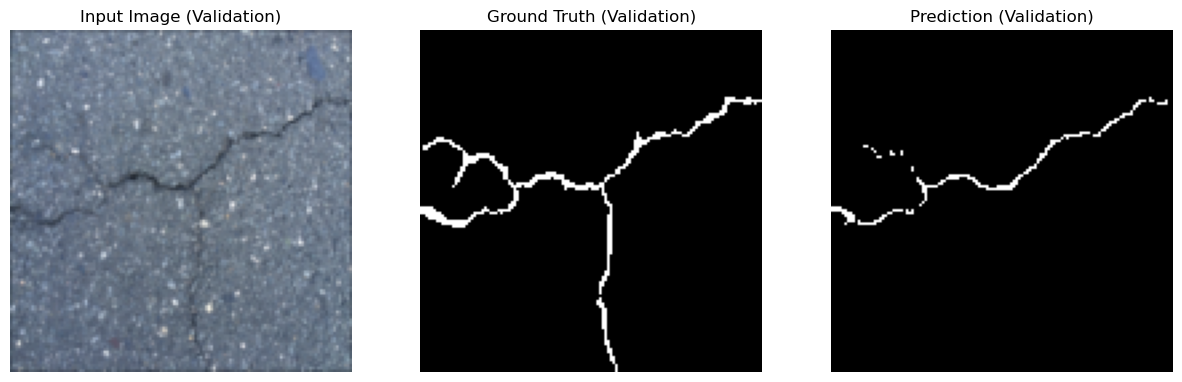

Test Images
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


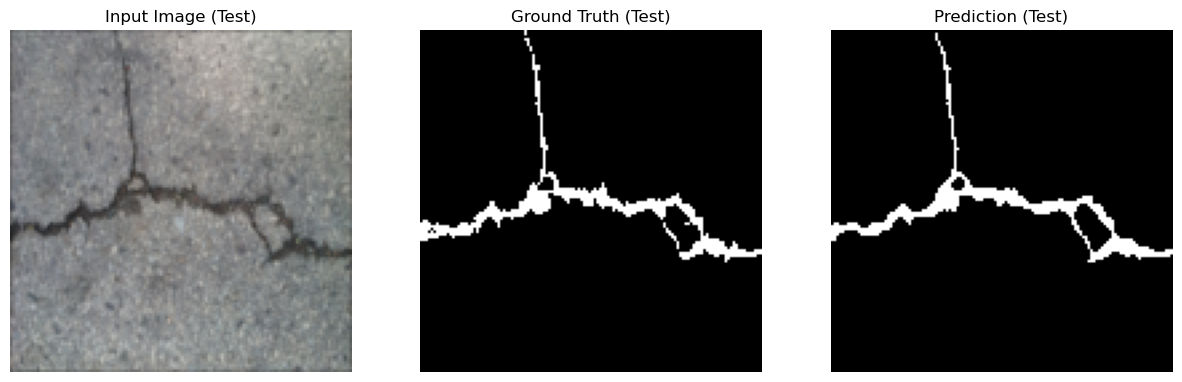

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf

# Ensure X_train is a valid array or tensor
if isinstance(X_train, (np.ndarray, tf.Tensor)):
    # Split index for train and validation subsets
    split_idx = int(X_train.shape[0] * 0.9)

    # Predictions on training subset
    preds_train = model.predict(X_train[:split_idx], verbose=1)

    # Predictions on validation subset
    preds_val = model.predict(X_train[split_idx:], verbose=1)
else:
    raise TypeError("X_train must be a NumPy array, TensorFlow tensor, or a compatible data structure.")

preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Function to display images horizontally with titles
def display_images_horizontally(images, titles, figsize=(15, 5)):
    plt.figure(figsize=figsize)
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(np.squeeze(image), cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()

print("Train Images")
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
train_images = [
    X_train[ix], 
    Y_train[ix], 
    preds_train_t[ix]
]
train_titles = ["Input Image", "Ground Truth", "Prediction"]
display_images_horizontally(train_images, train_titles)


print("Validation Images")
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
val_images = [
    X_train[int(X_train.shape[0] * 0.9):][ix],
    Y_train[int(Y_train.shape[0] * 0.9):][ix],
    preds_val_t[ix]
]
val_titles = ["Input Image (Validation)", "Ground Truth (Validation)", "Prediction (Validation)"]
display_images_horizontally(val_images, val_titles)

print("Test Images")
# Generate a random index for the test set
ix = random.randint(0, len(X_test) - 1)

# Perform inference on the selected test image
input_image = X_test[ix]  # Test input image
ground_truth = Y_test[ix]  # Corresponding ground truth
prediction = model.predict(input_image[np.newaxis, ...])  # Add batch dimension for prediction

# Post-process the prediction if needed (e.g., thresholding)
threshold = 0.5
predicted_mask = (prediction.squeeze() > threshold).astype("uint8")

# Prepare test images and titles
test_images = [
    input_image,          # Test input image
    ground_truth,         # Ground truth
    predicted_mask        # Model's predicted mask
]
test_titles = ["Input Image (Test)", "Ground Truth (Test)", "Prediction (Test)"]

# Function to display images horizontally
def display_images_horizontally(images, titles):
    plt.figure(figsize=(15, 5))
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image, cmap='gray')  # Adjust 'cmap' based on image format
        plt.title(title)
        plt.axis('off')
    plt.show()

# Display the test images
display_images_horizontally(test_images, test_titles)



# Metrics Calculation

In [ ]:
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score


# Flatten the true and predicted labels
true_labels = Y_test.flatten()  # Ground truth masks (ensure they are binary: 0 or 1)
predicted_labels = preds_test_t.flatten()  # Predicted masks from the model (binary: 0 or 1)

# Compute metrics
precision = precision_score(true_labels, predicted_labels, average='binary')
recall = recall_score(true_labels, predicted_labels, average='binary')
fscore = f1_score(true_labels, predicted_labels, average='binary')
accuracy = accuracy_score(true_labels, predicted_labels)

# Compute IoU (Jaccard Index)
iou = jaccard_score(true_labels, predicted_labels, average='binary')

# Print results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {fscore:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"IoU (Jaccard Index): {iou:.4f}")


Precision: 0.8255
Recall: 0.7567
F1-Score: 0.7896
Accuracy: 0.9863
IoU (Jaccard Index): 0.6524


# Confusion Matrix

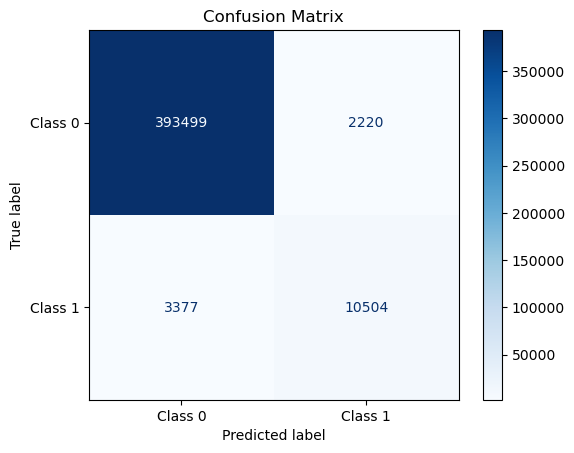

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np


# Ensure predictions and true labels are flattened
true_labels = Y_test.flatten()  # Assuming Y_test is the ground truth for X_test
predicted_labels = preds_test_t.flatten()

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()
